In [28]:
! pip install tensorflow scikit-learn torch torchvision pennylane umap-learn imbalanced-learn

In [29]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import umap
import joblib
from collections import Counter
import pennylane as qml

In [30]:
# ---------------------- CONFIG ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_qubits = 11
num_layers = 6
num_epochs = 50
batch_size = 32
learning_rate = 0.001
patience=10

In [31]:
# ---------------------- LOAD LABELS ----------------------
labels_df = pd.read_csv("experiment-ii_labels.csv")
base_dir = "experiment-ii"
file_paths, unique_labels = [], []

for _, row in labels_df.iterrows():
    full_path = os.path.join(base_dir, row["Subject"], row["Mat_Type"], row["File_Name"])
    if os.path.exists(full_path):
        file_paths.append(full_path)
        unique_labels.append(row["Label"])

label_mapping = {label: idx for idx, label in enumerate(sorted(set(unique_labels)))}
labels = [label_mapping[lbl] for lbl in unique_labels]

In [32]:
# ---------------------- SPLIT ----------------------
X_train_paths, X_test_paths, y_train, y_test = train_test_split(
    file_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

In [33]:

# ---------------------- UMAP REDUCTION ----------------------
X_train_raw = [MinMaxScaler().fit_transform(np.loadtxt(fp)).flatten() for fp in X_train_paths]
umap_model = umap.UMAP(n_components=num_qubits, random_state=42)
X_train_reduced = umap_model.fit_transform(X_train_raw)
joblib.dump(umap_model, "umap_model.pkl")

d:\QCNN\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\QCNN\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


['umap_model.pkl']

In [34]:
# ---------------------- SMOTE BALANCING ----------------------
sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train_reduced, y_train)


In [35]:
# ---------------------- QUANTUM LAYERS ----------------------
def QuantumConvLayer(inputs, weights):
    dev = qml.device("default.qubit", wires=num_qubits)

    @qml.qnode(dev, interface="torch")
    def circuit(x, w):
        qml.AngleEmbedding(x, wires=range(num_qubits))
        for l in range(num_layers):
            for i in range(num_qubits):
                qml.RY(w[l, i, 0], wires=i)
                qml.RZ(w[l, i, 1], wires=i)
            for i in range(0, num_qubits - 1, 2):
                qml.CNOT(wires=[i, i+1])
            for i in range(1, num_qubits - 1, 2):
                qml.CNOT(wires=[i, i+1])
        return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

    return circuit(inputs, weights)

def QuantumPoolingLayer(inputs):
    dev = qml.device("default.qubit", wires=num_qubits)

    @qml.qnode(dev, interface="torch")
    def circuit(x):
        qml.AngleEmbedding(x, wires=range(num_qubits))
        for i in range(0, num_qubits - 1, 2):
            qml.CNOT(wires=[i, i + 1])
            qml.Hadamard(wires=i)
        return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

    return circuit(inputs)

In [36]:
# ---------------------- MODEL ----------------------
class QCNN(nn.Module):
    def __init__(self):
        super(QCNN, self).__init__()
        self.q_params = nn.Parameter(0.01 * torch.randn(num_layers, num_qubits, 2))
        self.fc1 = nn.Linear(num_qubits, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.out = nn.Linear(32, len(set(y_train)))

    def forward(self, x, return_quantum_features=False):
        x = x.view(x.shape[0], -1)
        quantum_outputs = []
        for sample in x:
            conv_out = QuantumConvLayer(sample, self.q_params)
            pool_out = QuantumPoolingLayer(torch.tensor(conv_out, dtype=torch.float32))
            quantum_outputs.append(torch.tensor(pool_out, dtype=torch.float32))
        x = torch.stack(quantum_outputs).to(device)
        
        if return_quantum_features:
            return self.out(self.fc3(self.fc2(self.fc1(x)))), x  # return logits and quantum features

        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.3)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.2)
        x = F.relu(self.fc3(x))
        return self.out(x)


# ---------------------- DATASET & LOADERS ----------------------
class PressureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __len__(self): return len(self.features)
    def __getitem__(self, idx): return self.features[idx], self.labels[idx]

train_dataset = PressureDataset(X_train_balanced, y_train_balanced)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

X_test_raw = [MinMaxScaler().fit_transform(np.loadtxt(fp)).flatten() for fp in X_test_paths]
X_test_reduced = umap_model.transform(X_test_raw)
test_dataset = PressureDataset(X_test_reduced, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


d:\QCNN\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [37]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ---------------------- INIT ----------------------
model = QCNN().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Scheduler to reduce LR on plateau
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5, verbose=True)

# Early stopping setup
patience = 10
epochs_no_improve = 0
best_val_acc = 0.0
checkpoint_path = "qcnn2_model.pth"

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# ---------------------- TRAINING LOOP ----------------------
for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (output.argmax(1) == y).sum().item()
        total += y.size(0)

    train_acc = 100.0 * correct / total

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item()
            val_correct += (out.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_acc = 100.0 * val_correct / val_total

    print(f"Epoch {epoch+1:02d}: "
          f"Train Loss = {total_loss:.4f}, Train Acc = {train_acc:.2f}%, "
          f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.2f}%")

    train_losses.append(total_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Scheduler step (on validation accuracy)
    scheduler.step(val_acc)

    # Save best model and reset early stop counter
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), checkpoint_path)
        print(f"✅ New best model saved with Val Acc = {val_acc:.2f}%")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # Check early stopping condition
    if epochs_no_improve >= patience:
        print(f"🛑 Early stopping at epoch {epoch+1} (no improvement in {patience} epochs)")
        break

print("✅ Training complete.")


d:\QCNN\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 01: Train Loss = 23.0270, Train Acc = 33.49%, Val Loss = 3.4081, Val Acc = 21.51%
✅ New best model saved with Val Acc = 21.51%
Epoch 02: Train Loss = 21.4030, Train Acc = 35.33%, Val Loss = 3.6475, Val Acc = 23.66%
✅ New best model saved with Val Acc = 23.66%
Epoch 03: Train Loss = 21.2068, Train Acc = 37.17%, Val Loss = 3.5408, Val Acc = 23.66%
Epoch 04: Train Loss = 20.7760, Train Acc = 41.32%, Val Loss = 3.5216, Val Acc = 24.73%
✅ New best model saved with Val Acc = 24.73%
Epoch 05: Train Loss = 20.3020, Train Acc = 48.69%, Val Loss = 3.5901, Val Acc = 26.88%
✅ New best model saved with Val Acc = 26.88%
Epoch 06: Train Loss = 19.3720, Train Acc = 48.69%, Val Loss = 3.6351, Val Acc = 23.66%
Epoch 07: Train Loss = 18.8132, Train Acc = 49.62%, Val Loss = 3.5316, Val Acc = 24.73%
Epoch 08: Train Loss = 17.5985, Train Acc = 51.00%, Val Loss = 3.7650, Val Acc = 21.51%
Epoch 09: Train Loss = 18.3258, Train Acc = 49.16%, Val Loss = 3.6989, Val Acc = 24.73%
Epoch 10: Train Loss = 17.92

In [41]:
# ---------------------- TESTING ----------------------
# Load best saved model
model.load_state_dict(torch.load("qcnn2_model.pth"))
model.eval()

test_loss, test_correct, test_total = 0, 0, 0

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        loss = criterion(output, y)
        test_loss += loss.item()
        test_correct += (output.argmax(1) == y).sum().item()
        test_total += y.size(0)

test_acc = 100.0 * test_correct / test_total
avg_test_loss = test_loss / len(test_loader)

print(f"\n🧪 Final Test Accuracy: {test_acc:.2f}%")
print(f"🧪 Final Test Loss: {avg_test_loss:.4f}")



🧪 Final Test Accuracy: 22.58%
🧪 Final Test Loss: 1.2509


In [55]:
# Save full model for future prediction
torch.save(model.state_dict(), "qcnn2_model.pth")
print("💾 Full model saved for future inference.")

💾 Full model saved for future inference.


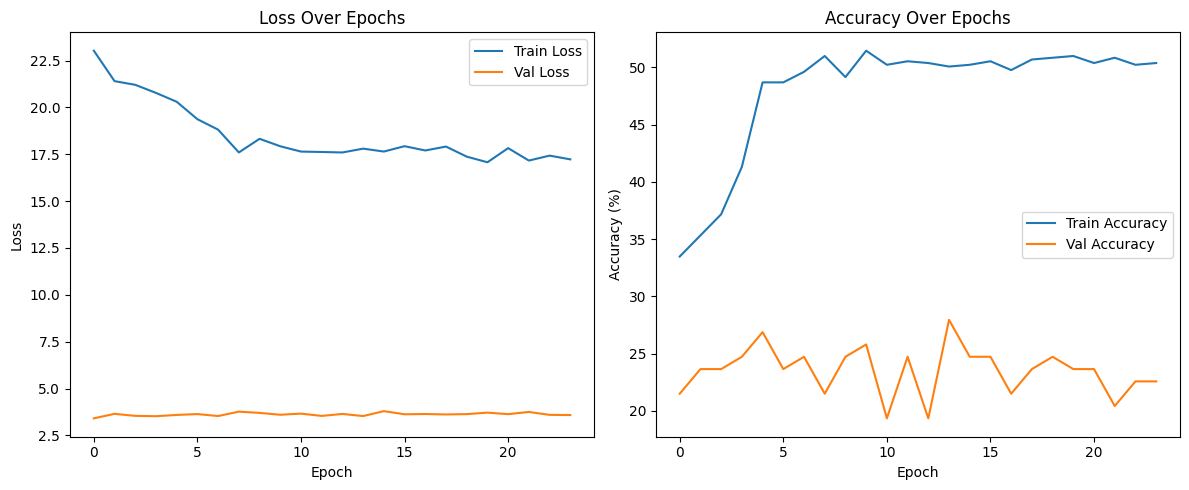

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()



📄 Classification Report:

              precision    recall  f1-score   support

        Left       0.24      0.55      0.33        20
       Right       0.21      0.53      0.30        19
      Supine       0.00      0.00      0.00        54

    accuracy                           0.23        93
   macro avg       0.15      0.36      0.21        93
weighted avg       0.09      0.23      0.13        93



d:\QCNN\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\QCNN\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\QCNN\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


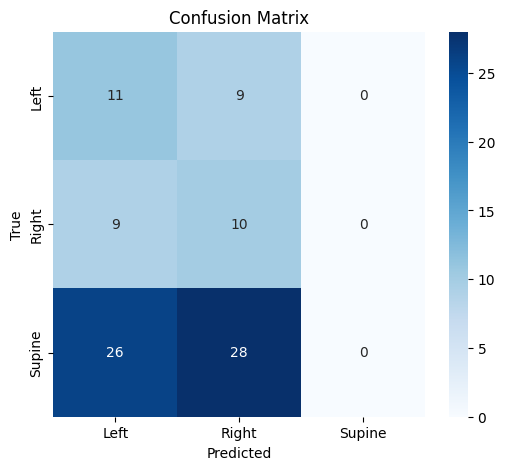

In [46]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import torch.serialization

# Add your model class to safe globals
torch.serialization.add_safe_globals([QCNN])

# Load the full model
model = torch.load("qcnn2_model.pth", weights_only=False)
model.eval()


all_preds, all_labels = [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        preds = out.argmax(1).cpu().numpy()
        labels = y.cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels)

# Report & Confusion Matrix
print("\n📄 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=label_mapping.keys()))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


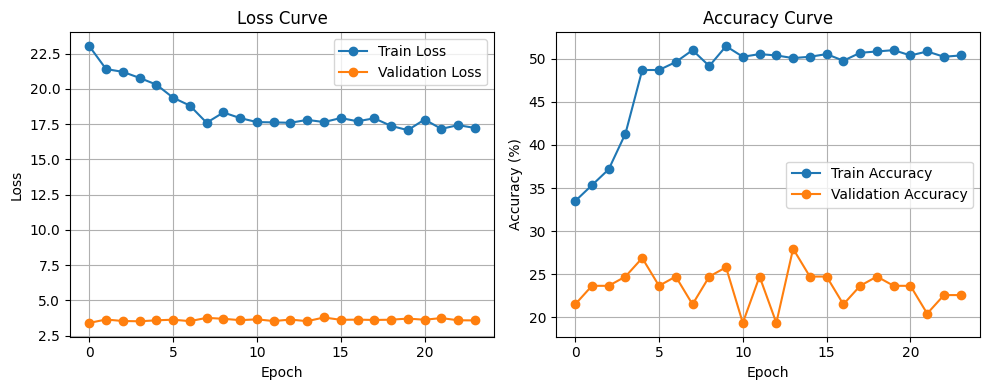

In [47]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


d:\QCNN\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


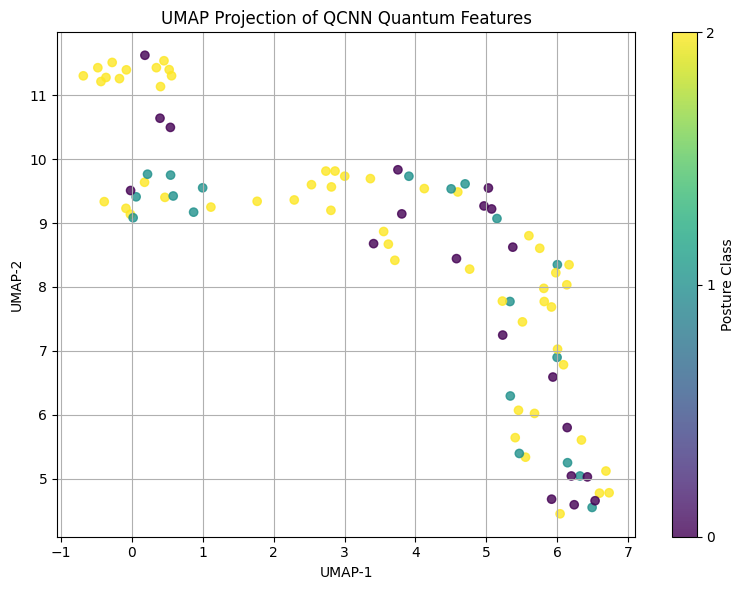

In [58]:
import umap
import matplotlib.pyplot as plt

model.eval()
quantum_features = []
quantum_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        _, q_feat = model(x, return_quantum_features=True)
        quantum_features.append(q_feat.cpu().numpy())
        quantum_labels.extend(y.numpy())

quantum_features = np.concatenate(quantum_features, axis=0)
quantum_labels = np.array(quantum_labels)

# UMAP projection
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
embedding = reducer.fit_transform(quantum_features)

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=quantum_labels, cmap='viridis', alpha=0.8)
plt.colorbar(scatter, ticks=[0, 1, 2], label="Posture Class")
plt.title("UMAP Projection of QCNN Quantum Features")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.tight_layout()
plt.show()


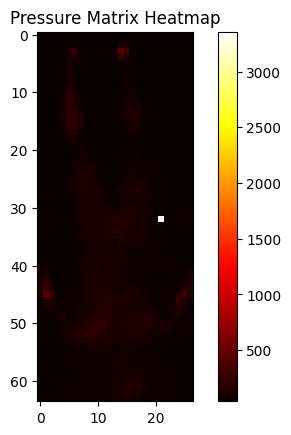

d:\QCNN\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Actual Posture   : Supine
✅ Predicted Posture: Left


In [59]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import joblib
import os

# Load UMAP model
pca = joblib.load("umap_model.pkl")

# Load label mapping
labels_df = pd.read_csv("experiment-ii_labels.csv")
label_mapping = {label: idx for idx, label in enumerate(sorted(labels_df['Label'].unique()))}
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Predict function using saved QCNN model
def predict_from_file(file_path):
    file_name = os.path.basename(file_path)  # Extract file name
    row = labels_df[labels_df['File_Name'] == file_name]

    if row.empty:
        print("❌ File not found in labels CSV.")
        return
    
    actual_label_text = row.iloc[0]['Label']
    actual_label = label_mapping[actual_label_text]

    # Load matrix
    matrix = np.loadtxt(file_path)

    # Show heatmap
    plt.imshow(matrix, cmap='hot', interpolation='nearest')
    plt.title("Pressure Matrix Heatmap")
    plt.colorbar()
    plt.show()

    # Normalize and apply UMAP
    matrix_scaled = MinMaxScaler().fit_transform(matrix).flatten()
    matrix_pca = pca.transform([matrix_scaled])[0]
    input_tensor = torch.tensor(matrix_pca, dtype=torch.float32).unsqueeze(0)

    # Load trained QCNN model
    model = QCNN()
    model.load_state_dict(torch.load("qcnn2_model.pth", map_location=torch.device('cpu')))
    model.eval()

    # Run inference
    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()

    print(f"✅ Actual Posture   : {actual_label_text}")
    print(f"✅ Predicted Posture: {reverse_label_mapping[pred]}")

# Example usage
predict_from_file("D:/QCNN/experiment-ii/S6/Sponge_Mat/Matrix_Sponge_B2.txt")
